# Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.

### Задание

1. Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью подходящих для задачи метрик.
5. Произведите подбор гиперпараметра K с использованием GridSearchCV и RandomizedSearchCV и кросс-валидации, оцените качество оптимальной модели. Используйте не менее двух стратегий кросс-валидации.
6. Сравните метрики качества исходной и оптимальной моделей.


## Выбор набора данных
Будем использовать `california_housing` - набор данных о стоимости жилья в Калифорнии для задачи регрессии.

In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")

In [30]:
california_housing = fetch_california_housing()

In [31]:
print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

## Проверка и заполнение пропусков

In [32]:
data = pd.DataFrame(data=california_housing.data, columns=california_housing.feature_names)
target = california_housing.target

In [33]:
data.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

In [34]:
pd.Series(target).isnull().sum()

0

In [35]:
# тип данных в столбцах
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


## Разделение выборки на обучающую и тестовую

In [36]:
# Разделим данные на обучающую и тестовую выборки в соотношении 80/20
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

In [37]:
# Размер обучающей выборки
X_train.shape, y_train.shape

((16512, 8), (16512,))

In [38]:
# Размер тестовой выборки
X_test.shape, y_test.shape

((4128, 8), (4128,))

## Обучение модели ближайших соседей

In [39]:
# Здесь произвольное значение k
k = 20
knn = KNeighborsRegressor(n_neighbors=k)


In [40]:
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [41]:
# Средне квадратичная ошибка
mse = mean_squared_error(y_test, y_pred)
mse

1.1487079504092799

In [42]:
y_pred_base = y_pred # сохраняем результаты для сравнения

## Подбор гиперпараметра K

### Подбор гиперпараметра K с использованием GridSearchCV

In [43]:
n_range = np.array(range(1,29,2))
param_grid = {'n_neighbors': n_range}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')

In [44]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27])},
             scoring='neg_mean_squared_error')

In [45]:
# Лучшая модель
grid_search.best_params_

{'n_neighbors': 9}

In [46]:
# Средне квадратичная ошибка лучшей модели
best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test)
mean_squared_error(y_test, y_pred_best)

1.103251681789815

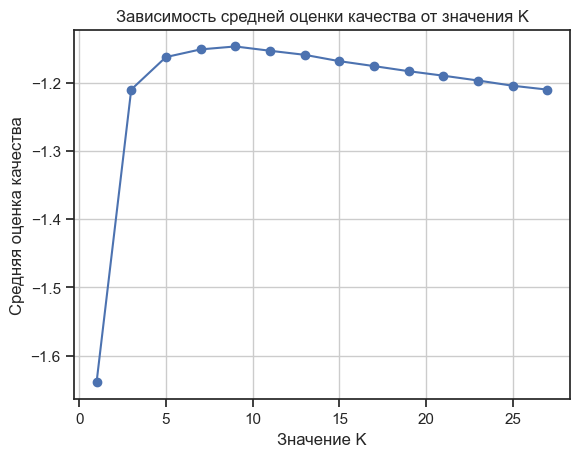

In [47]:
mean_test_scores = grid_search.cv_results_['mean_test_score']
plt.plot(n_range, mean_test_scores, marker='o')
plt.title('Зависимость средней оценки качества от значения K')
plt.xlabel('Значение K')
plt.ylabel('Средняя оценка качества')
plt.grid(True)
plt.show()

### Подбор гиперпараметра K с использованием RandomizedSearchCV

In [48]:
n_range = np.array(range(1,29,2))
param_dist = {'n_neighbors': n_range}
random_search = RandomizedSearchCV(KNeighborsRegressor(), param_dist, cv=5, scoring='neg_mean_squared_error', n_iter=5)

In [49]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsRegressor(), n_iter=5,
                   param_distributions={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27])},
                   scoring='neg_mean_squared_error')

In [50]:
# Лучшее значение гиперпараметра K (случайный поиск)
random_search.best_params_

{'n_neighbors': 7}

In [51]:
best_knn_random = random_search.best_estimator_
y_pred_best_random = best_knn_random.predict(X_test)
mean_squared_error(y_test, y_pred_best_random)

1.1045381245194705

## Сравнение метрик качества исходной и оптимальной моделей

Проверим качество исходной модели с k=15 и лучшей модели с k=9 по различным метрикам.

### Метрика Среднеквадратичная абсолютная ошибка

In [52]:
mae = mean_absolute_error(y_test, y_pred)
mae_best = mean_absolute_error(y_test, y_pred_best)
print("Mean Absolute Error (MAE) исходной модели:", mae)
print("Mean Absolute Error (MAE) оптимальной модели:", mae_best)


Mean Absolute Error (MAE) исходной модели: 0.8342932400678295
Mean Absolute Error (MAE) оптимальной модели: 0.815450576281223


### Метрика Среднеквадратичная ошибка

In [54]:
mse = mean_squared_error(y_test, y_pred)
mse_best = mean_squared_error(y_test, y_pred_best)
print("Mean Squared Error (MSE) исходной модели:", mse)
print("Mean Squared Error (MSE) оптимальной модели:", mse_best)

Mean Squared Error (MSE) исходной модели: 1.1487079504092799
Mean Squared Error (MSE) оптимальной модели: 1.103251681789815


### Метрика R2

In [53]:
r2 = r2_score(y_test, y_pred)
r2_best = r2_score(y_test, y_pred_best)
print("\nR-squared (R²) исходной модели:", r2)
print("R-squared (R²) оптимальной модели:", r2_best)


R-squared (R²) исходной модели: 0.12339737480178747
R-squared (R²) оптимальной модели: 0.1580859868109067
